# Data Processing

In [52]:
# Import necessary libraries
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import re
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDClassifier

# Set up tqdm for progress bars
tqdm.pandas()

## Remove Rows and Sample Randomly

We will now drop any rows that are irrelevant to us and save it to a CSV file.

In [38]:
# Load the dataset
df = pd.read_csv('data/Books_rating.csv')

# Keep only relevant columns and rename for ease of access
df = df[['review/summary', 'review/text', 'review/score']]
df.columns = ['summary', 'text', 'score']

# Sample a portion of the data
n = 125_000
df = df.sample(n=n, random_state=1)

# Save to a new CSV file and view data
df.to_csv('data/Books_rating_relevant_columns.csv', index=False)
df.head()

,summary,text,score
2896109,Best edition of this classic.,I've always recommended this Yale edition of F...,5.0
2381153,Great Book!!,This is required reading for my 16 yr old son....,5.0
1028690,Not just a book for consultant,"Plain-spoken, finished the book only has taken...",4.0
1945977,Outrageously Bad,Wow... this is one of the most ridiculous stor...,1.0
2812693,Cunning and determination,A crew has mutinied and threatens to hang thei...,4.0


## Stopwords, Lemmatization, and Vectorization

Process the text to remove stopwords, lemmatize, strip unneeded characters, then vectorize.

In [39]:
# Text processing: Remove stopwords, lemmatize, strip unneeded characters, then vectorize
lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))

def stemmer(text):
    if text != text:
        return ''

    # Clean the text
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.lower()

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if not w in stopwords]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    text = ' '.join(tokens)

    return text

In [40]:
# Apply stemmer to text
df['stemmed_text'] = df['text'].progress_apply(stemmer)
df['stemmed_summary'] = df['summary'].progress_apply(stemmer)
df['stemmed_summary_text'] = df['stemmed_summary'] + ' ' + df['stemmed_text']

# Remove trailing spaces
df['stemmed_summary_text'] = df['stemmed_summary_text'].progress_apply(
    lambda x: x.strip())

# Clean up NaN and remove empty rows
df.fillna('', inplace=True)
df = df[df['stemmed_summary_text'] != '']

# Drop unused columns
df.drop(columns=['text', 'summary', 'stemmed_summary',
        'stemmed_text'], inplace=True)

# Save to a new CSV file and view the data
df.to_csv('data/Books_rating_stemmed.csv', index=False)
df.head()

100%|██████████| 125000/125000 [00:00<00:00, 2527151.96it/s]


,score,stemmed_summary_text
2896109,5.0,best edition classic always recommended yale e...
2381153,5.0,great book required reading 16 yr old son book...
1028690,4.0,book consultant plain spoken finished book tak...
1945977,1.0,outrageously bad wow one ridiculous story ever...
2812693,4.0,cunning determination crew mutinied threatens ...


## Vectorizing

Vectorize the text using TF-IDF.

In [41]:
# Vectorize the text using TF-IDF
df = pd.read_csv('data/Books_rating_stemmed.csv')

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['stemmed_summary_text'], df['score'], test_size=0.2, random_state=1)

# Initialize the vectorizer and fit on the training set
vectorizer = TfidfVectorizer(max_features=30_000, sublinear_tf=True)
vectorizer.fit(X_train)

# Transform training and test sets
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Get the shape of training and test sets
print(f'Shape of training set: {X_train.shape}')
print(f'Shape of testing set: {X_test.shape}')

# Save vectorizer to disk
pickle.dump(vectorizer, open('models/vectorizer.pkl', 'wb'))
print('Vectorizer saved!')

Shape of training set: (599999, 30000)
Shape of testing set: (150000, 30000)
Vectorizer saved!


## Model Testing

First testing different kinds of models, then further testing with hyperparameters.

Classification Report for MultinomialNB:
              precision    recall  f1-score   support

         1.0       0.71      0.26      0.38     10159
         2.0       0.50      0.02      0.04      7622
         3.0       0.40      0.03      0.06     12715
         4.0       0.40      0.06      0.10     29264
         5.0       0.63      0.99      0.77     90240

    accuracy                           0.60     25000
   macro avg       0.44      0.21      0.18     25000
weighted avg       0.52      0.60      0.47     25000

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

         1.0       0.63      0.52      0.57      1660
         2.0       0.38      0.17      0.23      1276
         3.0       0.42      0.23      0.30      2179
         4.0       0.43      0.26      0.32      4892
         5.0       0.73      0.93      0.82     14993

    accuracy                           0.67     25000
   macro avg       0.52      0.42      0.45 

/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Classification Report for LinearSVC:
              precision    recall  f1-score   support

         1.0       0.63      0.62      0.62     10159
         2.0       0.44      0.20      0.28      7622
         3.0       0.47      0.24      0.31     12715
         4.0       0.46      0.27      0.34     29264
         5.0       0.75      0.94      0.83     90240

    accuracy                           0.66     25000
   macro avg       0.50      0.43      0.45     25000
weighted avg       0.62      0.66      0.63     25000

Classification Report for SDGClassifier:
              precision    recall  f1-score   support

         1.0       0.58      0.41      0.48      1660
         2.0       0.35      0.05      0.09      1276
         3.0       0.47      0.10      0.17      2179
         4.0       0.43      0.06      0.10      4892
         5.0       0.66      0.99      0.79     14993

    accuracy                           0.65     25000
   macro avg       0.50      0.32      0.33     25000

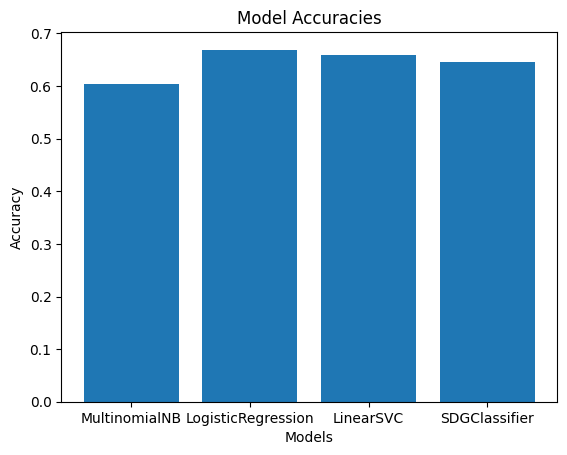

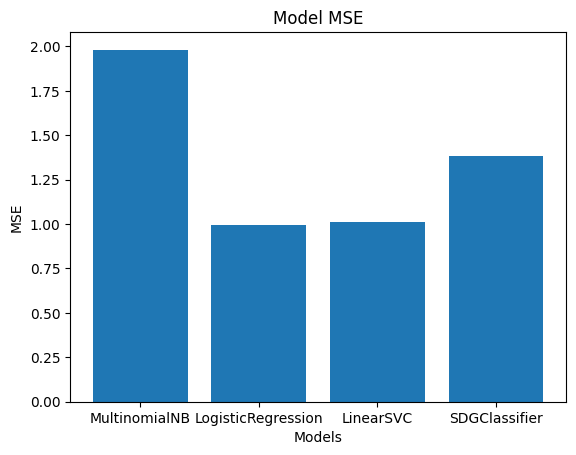

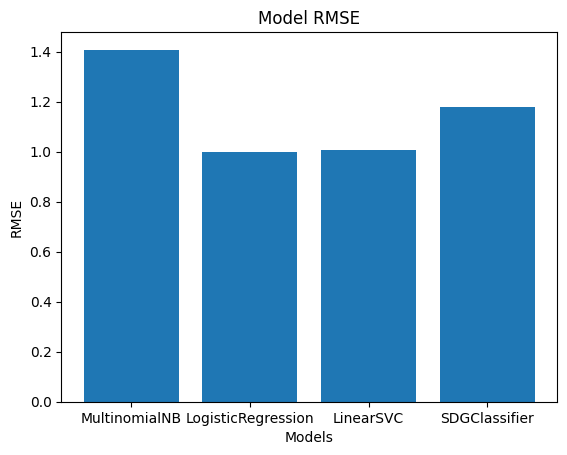

In [53]:
# Create a dictionary to store model instances
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(n_jobs=-1, solver='saga'),
    'LinearSVC': LinearSVC(),
    'SDGClassifier': SGDClassifier(n_jobs=-1),
}

# Create lists to store model names and accuracies for plotting
model_names = []
accuracies = []
mses = []
rmses = []

# Iterate through models
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    # Print classification report for more detailed metrics
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    
    # Store model name and accuracy for plotting
    model_names.append(name)
    accuracies.append(accuracy)
    mses.append(mse)
    rmses.append(rmse)

# Plotting accuracies
plt.bar(model_names, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

# plotting MSE
plt.bar(model_names, mses)
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('Model MSE')
plt.show()

# plotting RMSE
plt.bar(model_names, rmses)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model RMSE')
plt.show()

At this point we decided to further test the LogisticRegression and LinearSVC since the Naive Bayes did not produce favorable results.

### Logistic Regression

We are going to test the logistic regression model with different hyperparameters.

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. G

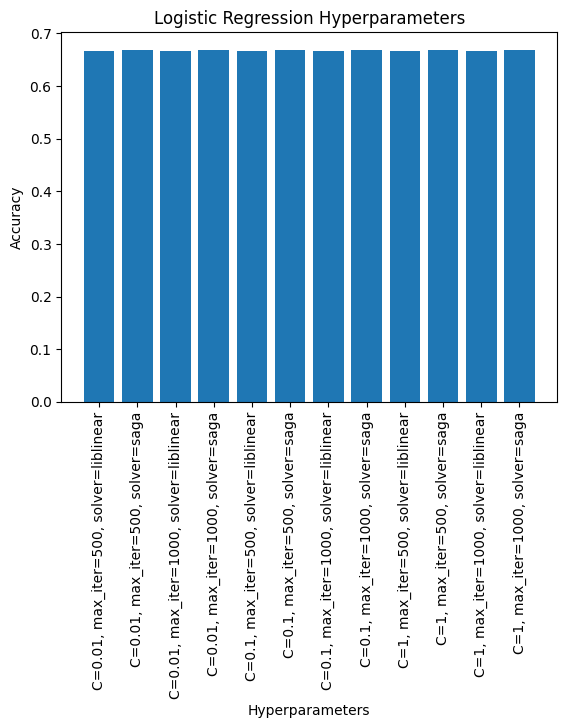

C=0.01, max_iter=500, solver=liblinear: 0.66764
C=0.01, max_iter=500, solver=saga: 0.66912
C=0.01, max_iter=1000, solver=liblinear: 0.66764
C=0.01, max_iter=1000, solver=saga: 0.66912
C=0.1, max_iter=500, solver=liblinear: 0.66764
C=0.1, max_iter=500, solver=saga: 0.66912
C=0.1, max_iter=1000, solver=liblinear: 0.66764
C=0.1, max_iter=1000, solver=saga: 0.66912
C=1, max_iter=500, solver=liblinear: 0.66764
C=1, max_iter=500, solver=saga: 0.66912
C=1, max_iter=1000, solver=liblinear: 0.66764
C=1, max_iter=1000, solver=saga: 0.66912


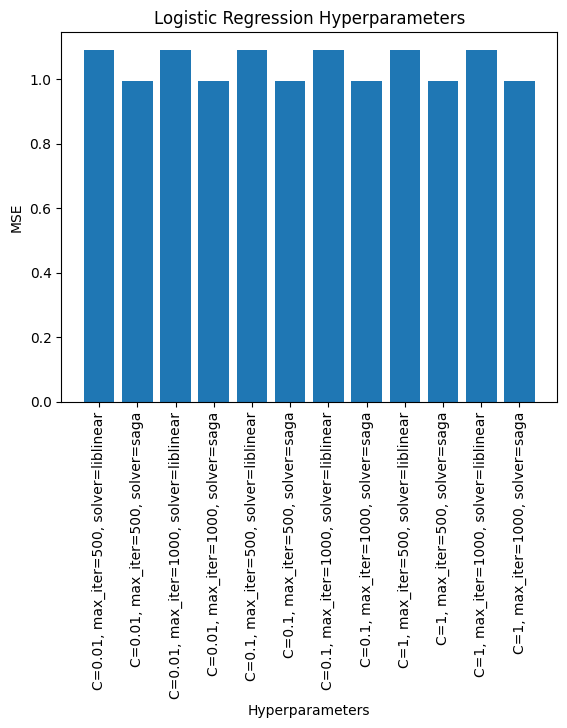

C=0.01, max_iter=500, solver=liblinear: 1.09096
C=0.01, max_iter=500, solver=saga: 0.99376
C=0.01, max_iter=1000, solver=liblinear: 1.09096
C=0.01, max_iter=1000, solver=saga: 0.99376
C=0.1, max_iter=500, solver=liblinear: 1.09096
C=0.1, max_iter=500, solver=saga: 0.99376
C=0.1, max_iter=1000, solver=liblinear: 1.09096
C=0.1, max_iter=1000, solver=saga: 0.99376
C=1, max_iter=500, solver=liblinear: 1.09096
C=1, max_iter=500, solver=saga: 0.99376
C=1, max_iter=1000, solver=liblinear: 1.09096
C=1, max_iter=1000, solver=saga: 0.99376


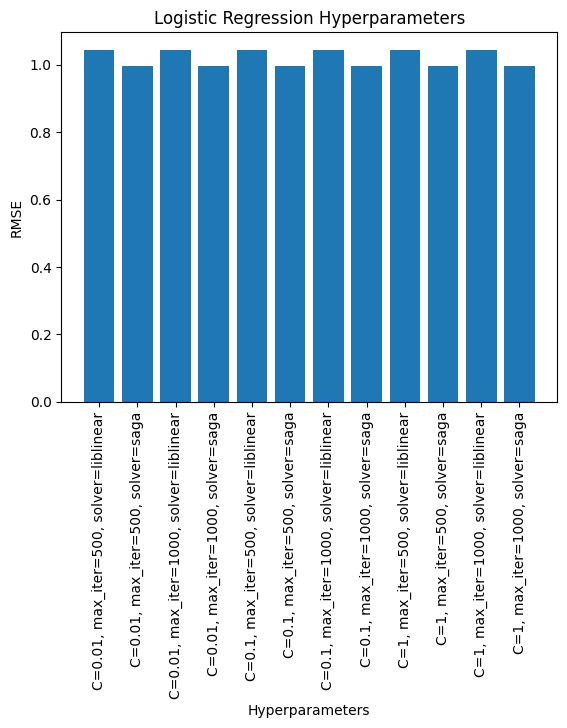

C=0.01, max_iter=500, solver=liblinear: 1.0444903063217006
C=0.01, max_iter=500, solver=saga: 0.996875117554852
C=0.01, max_iter=1000, solver=liblinear: 1.0444903063217006
C=0.01, max_iter=1000, solver=saga: 0.996875117554852
C=0.1, max_iter=500, solver=liblinear: 1.0444903063217006
C=0.1, max_iter=500, solver=saga: 0.996875117554852
C=0.1, max_iter=1000, solver=liblinear: 1.0444903063217006
C=0.1, max_iter=1000, solver=saga: 0.996875117554852
C=1, max_iter=500, solver=liblinear: 1.0444903063217006
C=1, max_iter=500, solver=saga: 0.996875117554852
C=1, max_iter=1000, solver=liblinear: 1.0444903063217006
C=1, max_iter=1000, solver=saga: 0.996875117554852


In [42]:
# Test Logistic Regression with various hyperparameters
penalty = 'l2'
C = [0.01, 0.1, 1]
max_iter = [500, 1000]
solver = ['liblinear', 'saga']
n_jobs = -1
random_state = 42

# Create lists to store hyperparameters and accuracies for plotting
params = []
accuracies = []
mses = []
rmses = []

# Iterate through hyperparameters
for c in C:
    for i in max_iter:
        for s in solver:
            # Create model instance
            model = LogisticRegression(penalty=penalty, max_iter=i, solver=s, n_jobs=n_jobs, random_state=random_state)
            
            # Test model and store results
            accuracy = model.fit(X_train, y_train).score(X_test, y_test)

            mse = mean_squared_error(y_test, model.predict(X_test))
            rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)

            params.append(f'C={c}, max_iter={i}, solver={s}')
            accuracies.append(accuracy)
            mses.append(mse)
            rmses.append(rmse)

# Plotting accuracies
plt.bar(params, accuracies)
plt.xlabel('Hyperparameters')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Hyperparameters')
plt.xticks(rotation=90)
plt.show()

# Print accuracies
for i in range(len(params)):
    print(f'{params[i]}: {accuracies[i]}')

# Plotting MSEs
plt.bar(params, mses)
plt.xlabel('Hyperparameters')
plt.ylabel('MSE')
plt.title('Logistic Regression Hyperparameters')
plt.xticks(rotation=90)
plt.show()

# Print MSEs
for i in range(len(params)):
    print(f'{params[i]}: {mses[i]}')

# Plotting RMSEs
plt.bar(params, rmses)
plt.xlabel('Hyperparameters')
plt.ylabel('RMSE')
plt.title('Logistic Regression Hyperparameters')
plt.xticks(rotation=90)
plt.show()

# Print RMSEs
for i in range(len(params)):
    print(f'{params[i]}: {rmses[i]}')

L1 and L2 regularization refer to Lasso and Ridge regression respectively. Lasso regression penalizes the absolute size of coefficients which results in some coefficients being set to zero. Ridge regression penalizes the squared size of coefficients which results in smaller coefficients but never zero.

Ridge tends to perform better for many significant predictors, while Lasso is more effective when only a few predictors are actually significant​​​. So, we decided to only test with Lasso.

### LinearSVC

We are going to test the LinearSVC model with different hyperparameters.

/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_clas

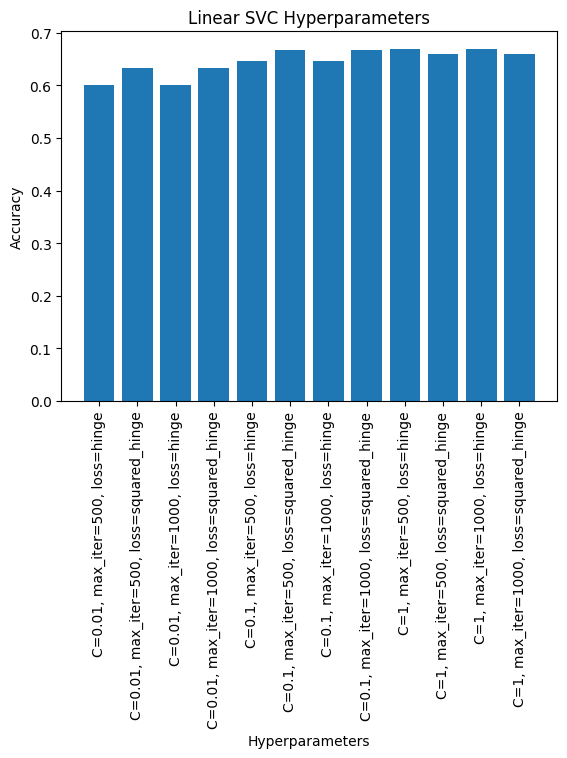

C=0.01, max_iter=500, loss=hinge: 0.60032
C=0.01, max_iter=500, loss=squared_hinge: 0.63208
C=0.01, max_iter=1000, loss=hinge: 0.60032
C=0.01, max_iter=1000, loss=squared_hinge: 0.63208
C=0.1, max_iter=500, loss=hinge: 0.64552
C=0.1, max_iter=500, loss=squared_hinge: 0.66776
C=0.1, max_iter=1000, loss=hinge: 0.64552
C=0.1, max_iter=1000, loss=squared_hinge: 0.66776
C=1, max_iter=500, loss=hinge: 0.6688
C=1, max_iter=500, loss=squared_hinge: 0.65896
C=1, max_iter=1000, loss=hinge: 0.6688
C=1, max_iter=1000, loss=squared_hinge: 0.65896


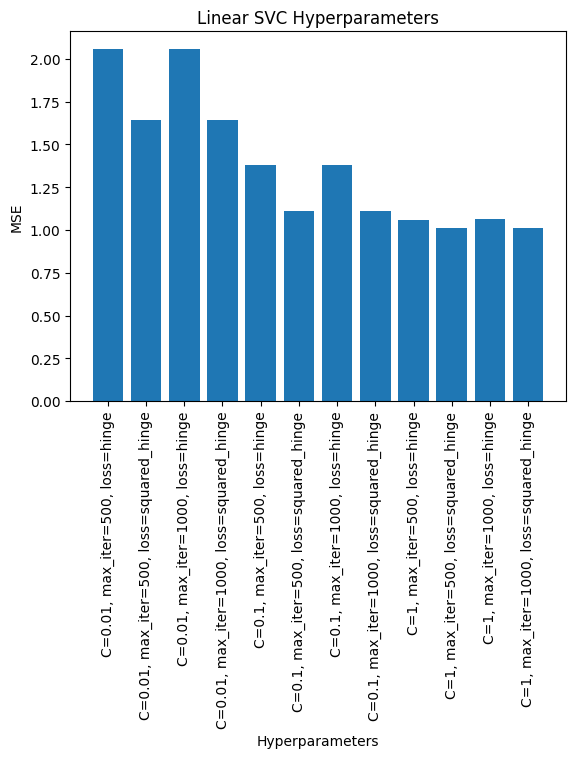

C=0.01, max_iter=500, loss=hinge: 2.05744
C=0.01, max_iter=500, loss=squared_hinge: 1.6402
C=0.01, max_iter=1000, loss=hinge: 2.05744
C=0.01, max_iter=1000, loss=squared_hinge: 1.6402
C=0.1, max_iter=500, loss=hinge: 1.3814
C=0.1, max_iter=500, loss=squared_hinge: 1.10944
C=0.1, max_iter=1000, loss=hinge: 1.3814
C=0.1, max_iter=1000, loss=squared_hinge: 1.10944
C=1, max_iter=500, loss=hinge: 1.06124
C=1, max_iter=500, loss=squared_hinge: 1.01216
C=1, max_iter=1000, loss=hinge: 1.06144
C=1, max_iter=1000, loss=squared_hinge: 1.01216


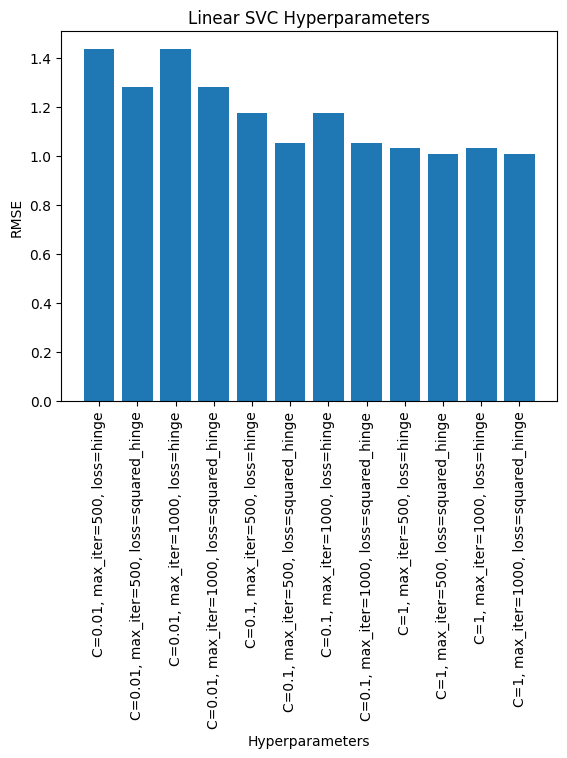

C=0.01, max_iter=500, loss=hinge: 1.4343779139403954
C=0.01, max_iter=500, loss=squared_hinge: 1.2807029319869616
C=0.01, max_iter=1000, loss=hinge: 1.4343779139403954
C=0.01, max_iter=1000, loss=squared_hinge: 1.2807029319869616
C=0.1, max_iter=500, loss=hinge: 1.1753297409663384
C=0.1, max_iter=500, loss=squared_hinge: 1.0532995775181913
C=0.1, max_iter=1000, loss=hinge: 1.1753297409663384
C=0.1, max_iter=1000, loss=squared_hinge: 1.0532995775181913
C=1, max_iter=500, loss=hinge: 1.0301650353220109
C=1, max_iter=500, loss=squared_hinge: 1.0060616283309884
C=1, max_iter=1000, loss=hinge: 1.0302621025739032
C=1, max_iter=1000, loss=squared_hinge: 1.0060616283309884


In [45]:
# Test Linear SVC with various hyperparameters
penalty = 'l2'
C = [0.01, 0.1, 1]
max_iter = [500, 1000]
loss = ['hinge', 'squared_hinge']
random_state = 42

# Create lists to store hyperparameters and accuracies for plotting
params = []
accuracies = []
mses = []
rmses = []

# Iterate through hyperparameters
for c in C:
    for i in max_iter:
        for l in loss:
            # Create model instance
            model = LinearSVC(C=c, penalty=penalty, max_iter=i, loss=l, random_state=random_state)
            
            # Test model and store results
            accuracy = model.fit(X_train, y_train).score(X_test, y_test)

            # calculate mse and rmse
            mse = mean_squared_error(y_test, model.predict(X_test))
            rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)

            params.append(f'C={c}, max_iter={i}, loss={l}')
            accuracies.append(accuracy)
            mses.append(mse)
            rmses.append(rmse)

# Plotting accuracies
plt.bar(params, accuracies)
plt.xlabel('Hyperparameters')
plt.ylabel('Accuracy')
plt.title('Linear SVC Hyperparameters')
plt.xticks(rotation=90)
plt.show()

# Print accuracies
for i in range(len(params)):
    print(f'{params[i]}: {accuracies[i]}')

# plotting mse
plt.bar(params, mses)
plt.xlabel('Hyperparameters')
plt.ylabel('MSE')
plt.title('Linear SVC Hyperparameters')
plt.xticks(rotation=90)
plt.show()

# Print MSEs
for i in range(len(params)):
    print(f'{params[i]}: {mses[i]}')

# plotting rmse
plt.bar(params, rmses)
plt.xlabel('Hyperparameters')
plt.ylabel('RMSE')
plt.title('Linear SVC Hyperparameters')
plt.xticks(rotation=90)
plt.show()

# Print RMSEs
for i in range(len(params)):
    print(f'{params[i]}: {rmses[i]}')

We started to notice that certain hyperparameters do not affect the accuracy at all in the context of this problem. You'll notice repitition in the output. However, logistic regression does edge out LinearSVC by just a little bit so we decided to stick with the configuration that produced those results. Honestly, being just the saga solver.

Chosen Model: `LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1, solver='saga')`

### Testing the Best Logistic Regression Model

This was tested using a larger sample size of data once we determined the best performing from above.

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Create model instance
model = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1, solver='saga')

# Test model and store results
accuracy = model.fit(X_train, y_train).score(X_test, y_test)

# Print accuracy (and parameters), rmse
print(f'Accuracy: {accuracy}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, model.predict(X_test)))}')

# Print detailed metrics
print(classification_report(y_test, model.predict(X_test)))

Accuracy: 0.6932733333333333
RMSE: 0.9256313160936882
              precision    recall  f1-score   support

         1.0       0.63      0.61      0.62     10159
         2.0       0.44      0.24      0.31      7622
         3.0       0.46      0.29      0.35     12715
         4.0       0.48      0.29      0.36     29264
         5.0       0.76      0.93      0.84     90240

    accuracy                           0.69    150000
   macro avg       0.55      0.47      0.50    150000
weighted avg       0.65      0.69      0.66    150000



## Supplementing Our Model

So, as a next step (before we attempt a nueral network) we decided to use sentiment analysis via VADER scores. We will then add these scores as features to our model and see if it improves the accuracy.

In [46]:
# Import necessary libraries for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy import sparse as sp

# Download the VADER lexicon
import nltk
nltk.download('vader_lexicon')

# Initialize the VADER Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis to the original 'text' column
df['vader_scores'] = df['stemmed_summary_text'].progress_apply(lambda x: sid.polarity_scores(x)['compound'])

# Save the DataFrame with VADER scores to a new CSV file
df.to_csv('data/Books_rating_vader_scores.csv', index=False)

# View the updated DataFrame
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/phillip/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████| 125000/125000 [00:50<00:00, 2499.09it/s]


,score,stemmed_summary_text,vader_scores
0,5.0,best edition classic always recommended yale e...,0.9952
1,5.0,great book required reading 16 yr old son book...,0.9022
2,4.0,book consultant plain spoken finished book tak...,0.7506
3,1.0,outrageously bad wow one ridiculous story ever...,-0.8935
4,4.0,cunning determination crew mutinied threatens ...,-0.4215


Let's perform additional testing using the new feature `vader_scores` and observe any changes in model performance.

In [47]:
# Vectorize the text and VADER scores using TF-IDF
X_text = vectorizer.transform(df['stemmed_summary_text'])
X_vader = df['vader_scores'].values.reshape(-1, 1)

# Concatenate the TF-IDF and VADER score features
X_combined = sp.hstack([X_text, X_vader], format='csr')

# Create train and test sets
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, df['score'], test_size=0.2, random_state=1)

# Initialize the logistic regression model
model_combined = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1, solver='saga')

# Fit the model on the combined features
model_combined.fit(X_train_combined, y_train)

# Predict on the test set
y_pred_combined = model_combined.predict(X_test_combined)

# Calculate accuracy and print classification report
accuracy_combined = accuracy_score(y_test, y_pred_combined)
mse_combined = mean_squared_error(y_test, y_pred_combined)
rmse_combined = mean_squared_error(y_test, y_pred_combined, squared=False)


print(f"Combined Model Accuracy: {accuracy_combined}")
print(f"Combined Model MSE: {mse_combined}")
print(f"Combined Model RMSE: {rmse_combined}")

print("Classification Report for Combined Model:")
print(classification_report(y_test, y_pred_combined))

Combined Model Accuracy: 0.6694
Combined Model MSE: 0.99392
Combined Model RMSE: 0.9969553650991603
Classification Report for Combined Model:
              precision    recall  f1-score   support

         1.0       0.62      0.53      0.57      1660
         2.0       0.40      0.17      0.24      1276
         3.0       0.43      0.23      0.30      2179
         4.0       0.43      0.26      0.32      4892
         5.0       0.73      0.92      0.82     14993

    accuracy                           0.67     25000
   macro avg       0.52      0.42      0.45     25000
weighted avg       0.62      0.67      0.63     25000



In [48]:
# only use VADER score to predict
# Create train and test sets
X_train_vader, X_test_vader, y_train, y_test = train_test_split(X_vader, df['score'], test_size=0.2, random_state=1)

# Initialize the logistic regression model
model_vader = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1, solver='saga')

# Fit the model on the combined features
model_vader.fit(X_train_vader, y_train)

# Predict on the test set
y_pred_vader = model_vader.predict(X_test_vader)

# Calculate accuracy and print classification report
accuracy_vader = accuracy_score(y_test, y_pred_vader)
mse_vader = mean_squared_error(y_test, y_pred_vader)
rmse_vader = mean_squared_error(y_test, y_pred_vader, squared=False)

print(f"VADER Model Accuracy: {accuracy_vader}")
print(f"VADER Model MSE: {mse_vader}")
print(f"VADER Model RMSE: {rmse_vader}")

print("Classification Report for VADER Model:")
print(classification_report(y_test, y_pred_vader))

VADER Model Accuracy: 0.59312
VADER Model MSE: 2.21008
VADER Model RMSE: 1.4866337814001134
Classification Report for VADER Model:
              precision    recall  f1-score   support

         1.0       0.20      0.10      0.14      1660
         2.0       0.00      0.00      0.00      1276
         3.0       0.00      0.00      0.00      2179
         4.0       0.00      0.00      0.00      4892
         5.0       0.61      0.98      0.75     14993

    accuracy                           0.59     25000
   macro avg       0.16      0.22      0.18     25000
weighted avg       0.38      0.59      0.46     25000



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now, let's observe and compare the results of using only the text, using VADER scores only, and combining both.

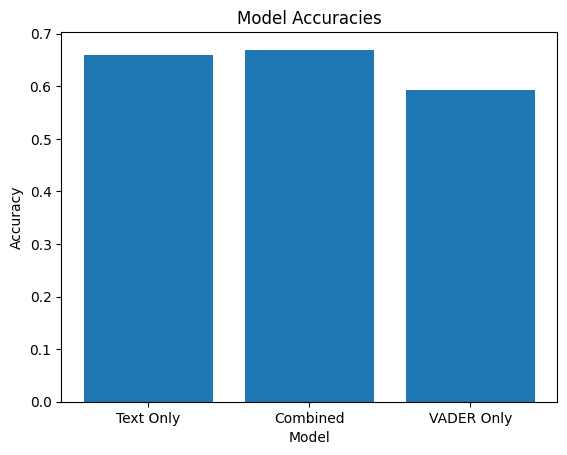

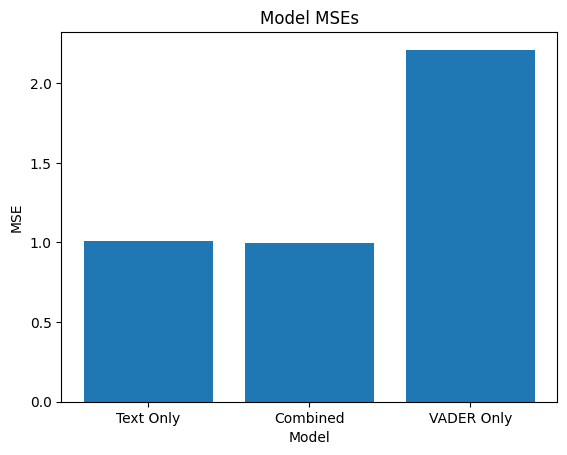

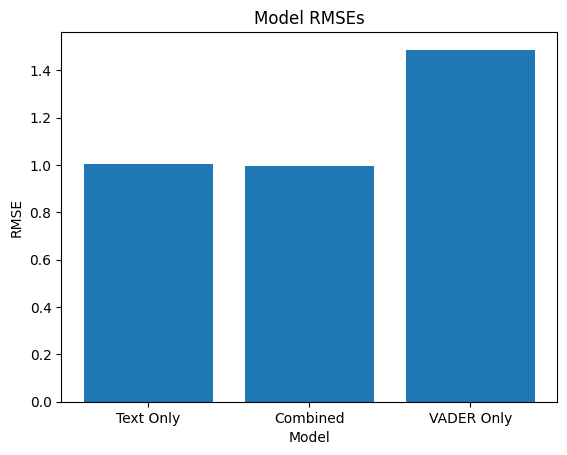

In [49]:
# plot a comparison of the accuracies
plt.bar(['Text Only', 'Combined', 'VADER Only'], [accuracy, accuracy_combined, accuracy_vader])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

# plot a comparison of the MSEs
plt.bar(['Text Only', 'Combined', 'VADER Only'], [mse, mse_combined, mse_vader])
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Model MSEs')
plt.show()

# plot a comparison of the RMSEs
plt.bar(['Text Only', 'Combined', 'VADER Only'], [rmse, rmse_combined, rmse_vader])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model RMSEs')
plt.show()

VADER scores did not improve the accuracy of our model. In fact, it made it worse. So, we will not be using VADER scores as a feature in our model.

In [13]:
from textblob import TextBlob

def textblob_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['textblob_scores'] = df['stemmed_summary_text'].progress_apply(textblob_sentiment)

df['review_length'] = df['stemmed_summary_text'].apply(len)
df['exclamation_count'] = df['stemmed_summary_text'].apply(lambda x: x.count('!'))

from scipy import sparse as sp

# TextBlob sentiment analysis
df['textblob_scores'] = df['stemmed_summary_text'].apply(textblob_sentiment)

# Additional features
df['review_length'] = df['stemmed_summary_text'].apply(len)
df['exclamation_count'] = df['stemmed_summary_text'].apply(lambda x: x.count('!'))

# Combine TF-IDF, VADER, and additional features
X_textblob = df['textblob_scores'].values.reshape(-1, 1)
X_length = df['review_length'].values.reshape(-1, 1)
X_exclamation = df['exclamation_count'].values.reshape(-1, 1)

X_combined = sp.hstack([X_text, X_textblob, X_length, X_exclamation], format='csr')

# Create train and test sets
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, df['score'], test_size=0.2, random_state=1)

# Initialize the logistic regression model
model_combined = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1, solver='saga')

# Fit the model on the combined features
model_combined.fit(X_train_combined, y_train)

# Predict on the test set
y_pred_combined = model_combined.predict(X_test_combined)

# Calculate accuracy and print classification report
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f"Combined Model Accuracy: {accuracy_combined}")
print("Classification Report for Combined Model:")
print(classification_report(y_test, y_pred_combined))

100%|██████████| 125000/125000 [00:27<00:00, 4570.45it/s]


Combined Model Accuracy: 0.59972
Classification Report for Combined Model:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      1660
         2.0       0.00      0.00      0.00      1276
         3.0       0.00      0.00      0.00      2179
         4.0       0.00      0.00      0.00      4892
         5.0       0.60      1.00      0.75     14993

    accuracy                           0.60     25000
   macro avg       0.12      0.20      0.15     25000
weighted avg       0.36      0.60      0.45     25000



/Users/dcmag/Documents/GitRepos/cs505-final-project/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dcmag/Documents/GitRepos/cs505-final-project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dcmag/Documents/GitRepos/cs505-final-project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dcmag/Documents/GitRepos/cs505-final-project/venv/lib/pytho

In [1]:
# Import necessary libraries
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import RMSprop
from sklearn.preprocessing import MinMaxScaler

with tf.device("/gpu:0"):
    # Load the preprocessed data
    df = pd.read_csv('data/Books_rating_vader_scores.csv')

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df['stemmed_summary_text'], df['score'], test_size=0.2, random_state=1)

    # Vectorize the text using TF-IDF
    vectorizer = TfidfVectorizer(max_features=30_000, sublinear_tf=True)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Build a simple neural network
    model = Sequential()
    model.add(Embedding(input_dim=30_000, output_dim=128, input_length=X_train_tfidf.shape[1]))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='linear'))  # Use 'linear' activation for regression tasks

    # Compile the model
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])

    # Set up early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Convert sparse matrices to dense arrays for compatibility with Keras
    X_train_dense = X_train_tfidf.toarray()
    X_test_dense = X_test_tfidf.toarray()

    # Add normalization before fitting the model
    scaler = MinMaxScaler()
    X_train_dense_scaled = scaler.fit_transform(X_train_dense)
    X_test_dense_scaled = scaler.transform(X_test_dense)

    # Train the model (10 takes waaaaay too long)
    model.fit(X_train_dense_scaled, y_train, epochs=5, batch_size=128, validation_data=(X_test_dense_scaled, y_test), callbacks=[early_stopping])

    # Save the model
    model.save('models/nn_model.h5')

    # Evaluate the model on the test set
    y_pred_nn = model.predict(X_test_tfidf).flatten().round().astype(int)

    # Calculate accuracy and print classification report
    accuracy_nn = accuracy_score(y_test, y_pred_nn)
    print(f"Neural Network Accuracy: {accuracy_nn}")
    print("Classification Report for Neural Network:")
    print(classification_report(y_test, y_pred_nn))

/Users/dcmag/Documents/GitRepos/cs505-final-project/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/5
782/782 [==============================] - 694s 887ms/step - loss: 147.3751 - mse: 147.3751 - val_loss: 13.5218 - val_mse: 13.5218
Epoch 2/5
782/782 [==============================] - 707s 903ms/step - loss: 11.0229 - mse: 11.0229 - val_loss: 8.7140 - val_mse: 8.7140
Epoch 3/5
782/782 [==============================] - 698s 892ms/step - loss: 6.8249 - mse: 6.8249 - val_loss: 5.1235 - val_mse: 5.1235
Epoch 4/5
782/782 [==============================] - 700s 894ms/step - loss: 3.8454 - mse: 3.8454 - val_loss: 2.7508 - val_mse: 2.7508
Epoch 5/5
782/782 [==============================] - 698s 892ms/step - loss: 2.0809 - mse: 2.0809 - val_loss: 1.5898 - val_mse: 1.5898


/Users/dcmag/Documents/GitRepos/cs505-final-project/venv/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2023-12-23 13:26:53.608299: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at serialize_sparse_op.cc:388 : INVALID_ARGUMENT: indices[1] = [0,29727] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.




InvalidArgumentError: {{function_node __wrapped__SerializeManySparse_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[1] = [0,29727] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse] name: 

Above we got an error related to the prediction. But we did finish training the model and saved it, so we will be testing it below!

In [5]:
# load in the model and evaluate it on the test set
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from scipy.sparse import csr_matrix
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report

# Load the model
model = load_model('models/nn_model.h5')

# Load the vectorizer
vectorizer = pickle.load(open('models/vectorizer.pkl', 'rb'))

# Load the test set
df = pd.read_csv('data/Books_rating_vader_scores.csv')
X_test = df['stemmed_summary_text']
y_test = df['score']

# Vectorize the text using TF-IDF
X_test_tfidf = vectorizer.transform(X_test)

# Convert sparse matrices to dense arrays for compatibility with Keras
X_test_dense = X_test_tfidf.toarray()

# Add normalization before fitting the model
scaler = MinMaxScaler()
X_test_dense_scaled = scaler.fit_transform(X_test_dense)

# Print shapes for debugging
print("X_test_dense_scaled shape:", X_test_dense_scaled.shape)
print("y_test shape:", y_test.shape)

# Evaluate the model on the test set
y_pred_nn = np.argmax(model.predict(X_test_dense_scaled), axis=1)

# Print shapes after prediction for debugging
print("y_pred_nn shape:", y_pred_nn.shape)

# Calculate accuracy and print classification report
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network Accuracy: {accuracy_nn}")
print("Classification Report for Neural Network:")
print(classification_report(y_test, y_pred_nn))

X_test_dense_scaled shape: (125000, 30000)
y_test shape: (125000,)
3907/3907 [==============================] - 248s 63ms/step
y_pred_nn shape: (125000,)
Neural Network Accuracy: 0.19476
Classification Report for Neural Network:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      8415
         2.0       0.00      0.00      0.00      6527
         3.0       0.00      0.00      0.00     10645
         4.0       0.19      1.00      0.33     24345
         5.0       0.00      0.00      0.00     75068

    accuracy                           0.19    125000
   macro avg       0.04      0.20      0.07    125000
weighted avg       0.04      0.19      0.06    125000



/Users/dcmag/Documents/GitRepos/cs505-final-project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dcmag/Documents/GitRepos/cs505-final-project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dcmag/Documents/GitRepos/cs505-final-project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control